# **PHOTOGRAPHIC RECIPE SEARCH**

Daniel Lu, Kooresh Akhbari, Defne Dilbaz, Yousif Alfuraiji

APS360 Team 32

**Important Team Notes**

*   This Google Colab file is in a shared folder called APS360-Project. Please make sure to copy this folder to your home directory on Google Drive — that is, the path to this file should be `drive/My Drive/APS360-Project/Project.ipynb` for everybody.



**Preliminary Code**

Code that needs to be run at the beginning of every project.

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
!pip install split-folders
import split_folders
import torchvision.models
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Code to Apply Transforms**

https://pytorch.org/docs/stable/torchvision/transforms.html

The ```apply_transform``` function is meant to apply a series of transforms. Passing in a list of numbers will apply those transforms, in the order that they are passed in. The table of transforms is given below.

```
 num | description            
  0  | no transform
  1  | random rotation
  2  | random brightness adjustment
  3  | grayscale
  4  | horizontal flip
  5  | vertical flip
  6  | random contrast adjustment
  7  | random hue adjustment
  8  | random saturation adjustment
```

For example, passing in ```num = [1,3,4]``` will return the ingredients dataset where each ingredient image has been randomly rotated, then greyscaled, then horizontally flipped.

If baseline is specified as True, the images will be scaled down to 50x50px. 

In [ ]:
!unzip 'drive/My Drive/2019-2020 (Third Year)/APS360/Local Project/Data/ingredients.zip' -d '/root/Ingredients'

In [2]:
def get_transform(num):
    """
    Helper function forwd apply_transform

    Parameters:
        num (int): number corresponding to transforms (see table above)
    
    Returns:
        Transform: transform (see table above)
    """
    transform = {
        1:transforms.RandomRotation(180),
        2:transforms.ColorJitter(brightness=0.3),
        3:transforms.Grayscale(3),
        4:transforms.RandomHorizontalFlip(p=1.0),
        5:transforms.RandomVerticalFlip(p=1.0),
        6:transforms.ColorJitter(contrast=0.2),
        7:transforms.ColorJitter(hue=0.1),
        8:transforms.ColorJitter(saturation=0.1)
    }
    return transform.get(num)


def apply_transform(nums, baseline=False, transfer=False):
    """
    Applies a list of input transforms in order on a dataset.

    Parameters:
        nums (list): A list of numbers representing transforms (see table above).
        baseline (bool): Whether this loader is being used for the baseline model or not
    
    Returns:
        ImageFolder: Ingredient dataset with the transforms applied in order.
    """

    # Create the array of transforms based on the input numbers
    transform_list = []
    if (baseline):
        transform_list.append(transforms.Resize((50,50)))
    elif (transfer):
        transform_list.append(transforms.Resize((224,224)))
    else:
        transform_list.append(transforms.CenterCrop(200))
    for n in nums:
        if 1 <= n <= 8:
            transform_list.append(get_transform(n))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

    # Initialize the transform object from the lsit of transforms
    transform = transforms.Compose(transform_list)

    # Load all ingredient with the given transform
    ingredient_dataset = datasets.ImageFolder(
        root = 'Ingredients',
        transform = transform
    )

    return ingredient_dataset

**Code for Augmenting and Loading Data**

The ```get_data_loader``` function returns the training, validation, and test loaders that will be used to train the neural network. 

In [3]:
def get_transformed_data(transformations, baseline=False, transfer=False):
    """
    Gets a dataset of all the transformations that the user specified

    Parameters:
        transformations (list): List of transformations that will be applied
        baseline (bool): Whether this function is being used for the baseline model or not

    Returns: List of datasets that got transformations applied
    """
    data_set = []
    transformations.append([0])
    
    for transforms in transformations:
        data_set.append(apply_transform(transforms, baseline, transfer))
    return data_set

In [4]:
def shuffle_indices(list_indicies):
    np.random.seed(1250)

    np.random.shuffle(list_indicies)

    list_len = len(list_indicies)
    train_cutoff = int(list_len * 0.6)
    val_cutoff = int(list_len * 0.8)

    train_indx_shuffled = list_indicies[:train_cutoff]
    val_indx_shuffled = list_indicies[train_cutoff:val_cutoff]
    test_indx_shuffled = list_indicies[val_cutoff:]

    return train_indx_shuffled, val_indx_shuffled, test_indx_shuffled

In [5]:
def get_data_loader(trans_list, batch_size, baseline=False, transfer=False):
    """
    Gets the training, validation, and test loaders.

    Parameters: 
        trans_list (list): List of lists that contains the transformations to be applied
                          eg: [[1,2,3], [1,4,2]]  
        batch_size (int): Desired batch size
        baseline (bool): Whether this function is being used for the baseline model or not
    
    Returns:
        DataLoader, DataLoader, DataLoader: training, validation, and test DataLoaders
    """

    classes = ['almond', 'apple', 'asparagus', 'bacon', 'banana', 'beef_ground',
               'beef_steak', 'beet', 'blueberries', 'brussel_sprout', 'bun_hamburger',
               'bun_hotdog', 'butter', 'cabbage', ' carrot', 'cauliflower', 'celery',
               'cheese_block', 'cheese_shredded', 'chicken_breast', 'chicken_leg',
               'chicken_wing', 'corn', 'croissant', 'cucumber', 'egg', 'garlic',
               'ginger', 'grape', 'honey', 'ketchup', 'lemon', 'lobster', 'mango',
               'mayonnaise', 'milk', 'mushroom', 'mustard', 'noodle', 'oil_vegetable', 
               'onion', 'orange', 'peach', 'pear', 'pepper_bell', 'pepper_chile', 
               'pineapple', 'potato', 'rice', 'salmon', 'sausage', 'scallion',
               'shrimp', 'spaghetti', 'spinach', 'thyme', 'tomato', 'vinegar']
    

    list_dataset = get_transformed_data(trans_list, baseline, transfer)
    #Concatenate the datasets into one big dataset
    dataset = ConcatDataset(list_dataset)

    print("Total number of pictures after transformataions: " + str(len(dataset)))

    #Shuffle indicies
    train_indices, val_indices, test_indices = shuffle_indices(list(range(len(dataset))))

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    #Load the data
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=test_sampler)
    

    print('Len train_loader: ', len(train_loader))
    print('Len val_loader: ', len(val_loader))
    print('Len test_loader: ', len(test_loader))

    if (baseline):
        print('All DataLoaders initialized for baseline model')
    elif (transfer):
        print('All DataLoaders initialized for transfer model')
    else:
        print('All DataLoaders initialized for full neural network')

    return train_loader, val_loader, test_loader, classes

**Code to Get DataLoaders for Baseline Model**

The following code initializes the train_loader, val_loader, and test_loader for the baseline model (50x50px images) and the full neural network (200x200px images). Once run, these values can be used directly in training the baseline model.

All labels in the DataLoaders are numerical figure (ex. 0 = almond, 1 = apple, etc.). The ```classes``` variable maps label numbers to ingredient names (ex. ```classes[0]``` will return ```'almond'```).

This code also prints the size of each DataLoader and the total number of pictures.

In [6]:
transformations_apply = [[2,6], [2,6,7,8], [2,6,1], [2,6,7,8,1], [2,6], [2,6,4], [2,6,7,8,5]]
batch = 32
train_loader_baseline, val_loader_baseline, test_loader_baseline, classes = get_data_loader(transformations_apply, batch_size=batch, baseline=True)
train_loader, val_loader, test_loader, classes = get_data_loader(transformations_apply, batch)
train_loader_transfer, val_loader_transfer, test_loader_transfer, classes = get_data_loader(transformations_apply, batch_size=batch, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  1404
Len val_loader:  468
Len test_loader:  468
All DataLoaders initialized for baseline model
Total number of pictures after transformataions: 84231
Len train_loader:  1580
Len val_loader:  527
Len test_loader:  527
All DataLoaders initialized for full neural network
Total number of pictures after transformataions: 93590
Len train_loader:  1755
Len val_loader:  585
Len test_loader:  585
All DataLoaders initialized for transfer model


**Code to Verify Images**

**THIS CODE DOES NOT NEED TO BE RUN.** The following code just visualizes some of the images in train_loader to make sure they are of acceptable quality. None of the following variables will be used anymore for the project.

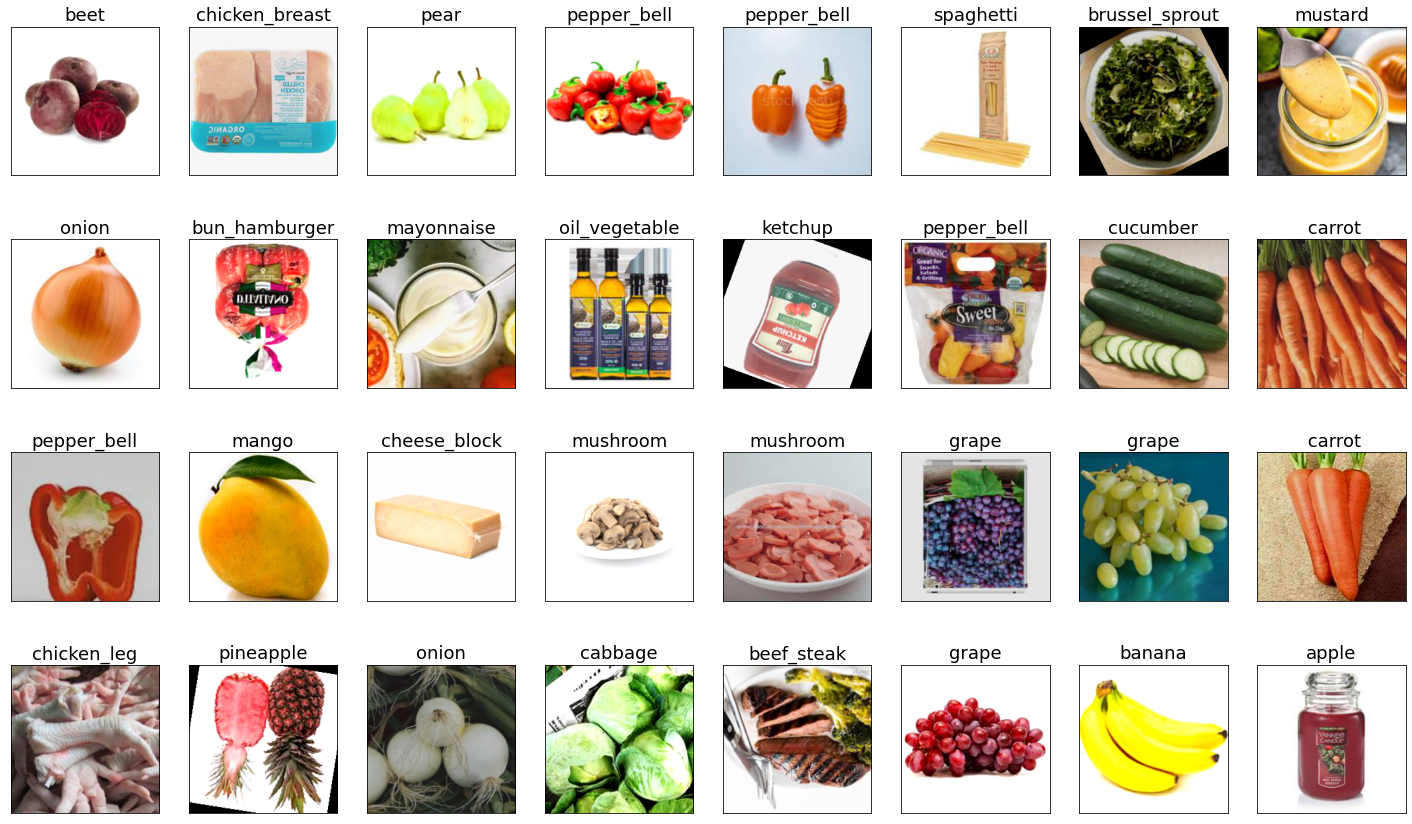

In [7]:
# THIS CODE DOES NOT NEED TO BE RUN

# obtain one batch of training images
dataiter = iter(train_loader_transfer)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
images = images / 2 + 0.5
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,15))
for idx in np.arange(32):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]], fontsize=18)

**Baseline Model**

NOTES TO YOUSIF AND DEFNE:

* Please make a local copy of the APS360-Project for training. MAKE SURE IT IS LOCAL!
* Please read all of the annotations above! You don't have to touch any of the above code, just run it (if you encounter issues, message Kooresh or Daniel)
* By running all of the above code, train_loader, val_loader, and test_loader have been initialized. Use these DataLoaders to train your code.
* Please remember to keep track of all architectures you train in https://docs.google.com/spreadsheets/d/1oQcA4yKam8iQfyHtsZV9JOXIjvXUS3MCSUgjVc9QBIU/edit?usp=sharing

**Code to Train a Given Model**

The following trains a model, saves the new parameters, and plots the resulting performance.

Note: `get_data_loader` function is called in train to keep the batch size consistent everytime.

Another note: we might want to randomize the `transformations_apply` vector inside of the train function later.

In [8]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    dir_path = name + "-bs" + str(batch_size) + "-lr" + str(learning_rate)
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
    path = dir_path + "/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path



def get_accuracy(model, data_loader, transfer=False):
    """ Calculates accuracy for a given model and a given data_loader
    Args:
      model: ANN model
      data_loader: one of val_loader, train_loader, test_loader, etc
    Returns:
      correct/total = correct labelled images/ total number of images
    """
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = None
        if (transfer):
            output = model(alexnet.features(imgs))
        else:
            output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total



def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation acc/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = train_acc.size # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()

        # labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss



def transfer_loader(train_loader, val_loader, test_loader):
    
    training_features = None
    training_labels = None
    val_features = None
    val_labels = None
    test_features = None
    test_labels = None

    # Get features from first batch
    for i, data in enumerate(train_loader, 0):
        training_inputs, training_labels = data
        training_features = alexnet.features(training_inputs)
        break

    for i, data in enumerate(val_loader, 0):
        val_inputs, val_labels = data
        val_features = alexnet.features(val_inputs)
        break

    for i, data in enumerate(test_loader, 0):
        test_inputs, test_labels = data
        test_features = alexnet.features(test_inputs)
        break

    training_features = torch.from_numpy(training_features.detach().numpy())
    training_dataset = torch.utils.data.TensorDataset(training_features, training_labels)
    train_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 256, num_workers = 1)
    val_features = torch.from_numpy(val_features.detach().numpy())
    val_dataset = torch.utils.data.TensorDataset(val_features, val_labels)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 256, num_workers = 1)
    test_features = torch.from_numpy(test_features.detach().numpy())
    test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256, num_workers = 1)
    
    return train_loader, val_loader, test_loader



def train(model, batch_size=32, num_epochs=1, learning_rate=1e-2, baseline=False, transfer=False):

    assert (baseline != transfer)

    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Load the Data
    transformations_apply = [[2,6], [2,6,7,8], [2,6,1], [2,6,7,8,1], [2,6], [2,6,4], [2,6,7,8,5]]
    train_loader, val_loader, test_loader, classes = get_data_loader(transformations_apply, batch_size, baseline, transfer)

    # Set the loss and optimizers
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_acc, val_acc, train_loss, val_loss= [], [], [], []
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    count = 0
    total_time = 0
    for epoch in range(num_epochs):

        # get start time to see how fast your model is for each epoch
        start_time = time.time()
        cur_time = time.time()
        total_train_loss = 0.0
        train_iterations = 0
        for imgs, labels in iter(train_loader):
            
            count += 1
            if (count % 10 == 0):
              print("{0} elapsed time: {1}".format(count, time.time()-cur_time))
            cur_time = time.time()
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            outputs = model(alexnet.features(imgs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()
            train_iterations += 1
        
        total_val_loss = 0.0
        val_iterations = 0

        count = 0
        for imgs, labels in iter(val_loader):
          
            count += 1
            # print(count)
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              
            outputs = model(alexnet.features(imgs))
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            val_iterations += 1
        
        train_acc[epoch] = get_accuracy(model, train_loader, transfer)
        train_loss[epoch] = float(total_train_loss) / train_iterations
        val_acc[epoch] = get_accuracy(model, val_loader, transfer)
        val_loss[epoch] = float(total_val_loss) / val_iterations

        total_time += time.time()-start_time

        print("epoch: ", epoch)
        print("Elapsed time: {0}".format(time.time()-start_time))
        print("train acc: {0} train loss: {1} val acc: {2} val loss: {3}".format(train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Average time per epoch: {0}".format(total_time/num_epochs))

    model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs - 1)
    plot_training_curve(model_path)    

**Code for Baseline Model**

Let's define a very basic model and test it

Let's train a transfer model!

In [9]:
class Transfer1(nn.Module):
    def __init__(self):
        super(Transfer1, self).__init__()
        self.name = "Transfer1_Kooresh"
        self.conv1 = nn.Conv2d(256, 30, 2)
        self.fc1 = nn.Linear(30 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 30 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
class Transfer2(nn.Module):
    def __init__(self):
        super(Transfer2, self).__init__()
        self.name = "Transfer2_Kooresh"
        self.conv1 = nn.Conv2d(256, 100, 2)
        self.fc1 = nn.Linear(100 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 100 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
class Transfer3(nn.Module):
    def __init__(self):
        super(Transfer3, self).__init__()
        self.name = "Kooresh_Transfer3"
        self.conv1 = nn.Conv2d(256, 70, 2)
        self.fc1 = nn.Linear(70 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 70 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
class Transfer4(nn.Module):
    def __init__(self):
        super(Transfer4, self).__init__()
        self.name = "Transfer4Kooresh"
        self.conv1 = nn.Conv2d(256, 70, 2)
        self.fc1 = nn.Linear(70 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 70 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


10 elapsed time: 1.204226016998291
20 elapsed time: 1.2241425514221191
30 elapsed time: 1.227210283279419
40 elapsed time: 1.237673044204712
50 elapsed time: 1.258643388748169
60 elapsed time: 1.2762625217437744
70 elapsed time: 1.214881181716919
80 elapsed time: 1.279862642288208
90 elapsed time: 1.2228200435638428
100 elapsed time: 1.3174116611480713
110 elapsed time: 1.205644130706787
120 elapsed time: 1.2617709636688232
130 elapsed time: 1.2937464714050293
140 elapsed time: 1.2622935771942139
150 elapsed time: 1.2746095657348633
160 elapsed time: 1.200488805770874
170 elapsed time: 1.2101502418518066


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  0
Elapsed time: 597.960676908493
train acc: 0.3823876410747279 train loss: 3.190172637050802 val acc: 0.37571791104581276 val loss: 2.4853770571239924
60 elapsed time: 1.3170969486236572


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.1570484638214111
80 elapsed time: 1.2084417343139648
90 elapsed time: 1.2872018814086914
100 elapsed time: 1.2178587913513184
110 elapsed time: 1.2112436294555664
120 elapsed time: 1.2449028491973877
130 elapsed time: 1.3272061347961426
140 elapsed time: 1.142768383026123
150 elapsed time: 1.215325117111206
160 elapsed time: 1.2446205615997314
170 elapsed time: 1.5041813850402832
180 elapsed time: 1.242387294769287
190 elapsed time: 1.1657400131225586
200 elapsed time: 1.15336275100708
210 elapsed time: 1.2954490184783936
220 elapsed time: 1.1474182605743408
230 elapsed time: 1.2483055591583252


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  1
Elapsed time: 588.3071267604828
train acc: 0.5274358346504018 train loss: 2.1679051823236724 val acc: 0.5238413249632696 val loss: 1.9295364719326213
60 elapsed time: 1.299769639968872


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.1614165306091309
80 elapsed time: 1.2132072448730469
90 elapsed time: 1.2218577861785889
100 elapsed time: 1.4857888221740723
110 elapsed time: 1.1810462474822998
120 elapsed time: 1.2183279991149902
130 elapsed time: 1.2935965061187744
140 elapsed time: 1.1574463844299316
150 elapsed time: 1.2438075542449951
160 elapsed time: 1.2543919086456299
170 elapsed time: 1.1952192783355713
180 elapsed time: 1.2242510318756104
190 elapsed time: 1.2758769989013672
200 elapsed time: 1.2396774291992188
210 elapsed time: 1.2473444938659668
220 elapsed time: 1.262787103652954
230 elapsed time: 1.2200944423675537


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  2
Elapsed time: 591.8279070854187
train acc: 0.5917236159650958 train loss: 1.7729115120389245 val acc: 0.5816081207426206 val loss: 1.6512098898321896
60 elapsed time: 1.278745174407959


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.2397449016571045
80 elapsed time: 1.2082502841949463
90 elapsed time: 1.45090913772583
100 elapsed time: 1.5087590217590332
110 elapsed time: 1.2275021076202393
120 elapsed time: 1.232800006866455
130 elapsed time: 1.24820876121521
140 elapsed time: 1.235004186630249
150 elapsed time: 1.233665943145752
160 elapsed time: 1.321690320968628
170 elapsed time: 1.1719906330108643
180 elapsed time: 1.3162615299224854
190 elapsed time: 1.3688621520996094
200 elapsed time: 1.2290091514587402
210 elapsed time: 1.2768762111663818
220 elapsed time: 1.252108097076416
230 elapsed time: 1.2587847709655762


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  3
Elapsed time: 594.8809702396393
train acc: 0.6256038109654297 train loss: 1.5531923750584775 val acc: 0.6164017630559637 val loss: 1.4781387923127514
60 elapsed time: 1.294724702835083


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.2443809509277344
80 elapsed time: 1.2835044860839844
90 elapsed time: 1.3151960372924805
100 elapsed time: 1.2372474670410156
110 elapsed time: 1.3369803428649902
120 elapsed time: 1.1513917446136475
130 elapsed time: 1.2574219703674316
140 elapsed time: 1.2573521137237549
150 elapsed time: 1.1928553581237793
160 elapsed time: 1.3865535259246826
170 elapsed time: 1.254629373550415
180 elapsed time: 1.252676248550415
190 elapsed time: 1.247429370880127
200 elapsed time: 1.225940465927124
210 elapsed time: 1.2961699962615967
220 elapsed time: 1.2750937938690186
230 elapsed time: 1.2850561141967773


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  4
Elapsed time: 588.9395818710327
train acc: 0.6516483761102331 train loss: 1.406629080799493 val acc: 0.6363697074929878 val loss: 1.36327804953365
60 elapsed time: 1.3054120540618896


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.2436375617980957
80 elapsed time: 1.2174651622772217
90 elapsed time: 1.2073707580566406
100 elapsed time: 1.2008976936340332
110 elapsed time: 1.2587437629699707
120 elapsed time: 1.4882075786590576
130 elapsed time: 1.3095412254333496
140 elapsed time: 1.293900489807129
150 elapsed time: 1.2178657054901123
160 elapsed time: 1.2186377048492432
170 elapsed time: 1.211012840270996
180 elapsed time: 1.328885793685913
190 elapsed time: 1.2245776653289795
200 elapsed time: 1.2398691177368164
210 elapsed time: 1.3495807647705078
220 elapsed time: 1.5267775058746338
230 elapsed time: 1.217710018157959


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  5
Elapsed time: 589.0897555351257
train acc: 0.6703915588896556 train loss: 1.3012468665838242 val acc: 0.6576733003873381 val loss: 1.2815573235689584
60 elapsed time: 1.3661949634552002


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.2636423110961914
80 elapsed time: 1.1883947849273682
90 elapsed time: 1.2628133296966553
100 elapsed time: 1.276759386062622
110 elapsed time: 1.246675968170166
120 elapsed time: 1.2093234062194824
130 elapsed time: 1.1499354839324951
140 elapsed time: 1.326237440109253
150 elapsed time: 1.220789909362793
160 elapsed time: 1.3254814147949219
170 elapsed time: 1.2167472839355469
180 elapsed time: 1.240649700164795
190 elapsed time: 1.1886029243469238
200 elapsed time: 1.4641525745391846
210 elapsed time: 1.2519111633300781
220 elapsed time: 1.2483925819396973
230 elapsed time: 1.309103012084961


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  6
Elapsed time: 591.4548382759094
train acc: 0.6854395298622087 train loss: 1.2220836898142642 val acc: 0.6731668224923201 val loss: 1.2211246995602625
60 elapsed time: 1.276562213897705


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.2593810558319092
80 elapsed time: 1.3071503639221191
90 elapsed time: 1.2077298164367676
100 elapsed time: 1.2662935256958008
110 elapsed time: 1.2101695537567139
120 elapsed time: 1.304062843322754
130 elapsed time: 1.225597620010376
140 elapsed time: 1.256380319595337
150 elapsed time: 1.265962839126587
160 elapsed time: 1.4516081809997559
170 elapsed time: 1.299426794052124
180 elapsed time: 1.1890285015106201
190 elapsed time: 1.2856268882751465
200 elapsed time: 1.2373743057250977
210 elapsed time: 1.3022217750549316
220 elapsed time: 1.277219295501709
230 elapsed time: 1.2892935276031494


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  7
Elapsed time: 588.4451246261597
train acc: 0.700732364267747 train loss: 1.1547246175733479 val acc: 0.6834513156137305 val loss: 1.1720721741854134
60 elapsed time: 1.3113889694213867


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.244598150253296
80 elapsed time: 1.27366042137146
90 elapsed time: 1.2041335105895996
100 elapsed time: 1.2996630668640137
110 elapsed time: 1.2395045757293701
120 elapsed time: 1.1906547546386719
130 elapsed time: 1.2213380336761475
140 elapsed time: 1.3200652599334717
150 elapsed time: 1.2076308727264404
160 elapsed time: 1.309791088104248
170 elapsed time: 1.1944258213043213
180 elapsed time: 1.234713077545166
190 elapsed time: 1.4226112365722656
200 elapsed time: 1.2173113822937012
210 elapsed time: 1.1845436096191406
220 elapsed time: 1.4123337268829346
230 elapsed time: 1.1726021766662598


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  8
Elapsed time: 581.6599931716919
train acc: 0.7130868374774615 train loss: 1.0992158573459496 val acc: 0.6879257379457727 val loss: 1.1261328903295227
60 elapsed time: 1.2459590435028076


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


70 elapsed time: 1.2828154563903809
80 elapsed time: 1.2265138626098633
90 elapsed time: 1.2527918815612793
100 elapsed time: 1.202392339706421
110 elapsed time: 1.192382574081421
120 elapsed time: 1.396972894668579
130 elapsed time: 1.2167766094207764
140 elapsed time: 1.169586181640625
150 elapsed time: 1.189061164855957
160 elapsed time: 1.1370368003845215
170 elapsed time: 1.1850521564483643
180 elapsed time: 1.2218236923217773
190 elapsed time: 1.276843547821045
200 elapsed time: 1.2104394435882568
210 elapsed time: 1.2508642673492432
220 elapsed time: 1.1983938217163086
230 elapsed time: 1.2454984188079834


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f91a05e9050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

epoch:  9
Elapsed time: 585.8564171791077
train acc: 0.7257752153685195 train loss: 1.0486165803264489 val acc: 0.7052223854681448 val loss: 1.0814746193966622
Average time per epoch: 589.8420424938201


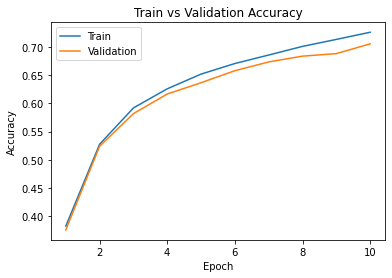

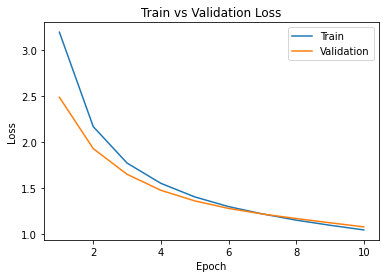

In [46]:
#Kooresh
kooresh_transfer1 = Transfer1()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer1.cuda()
    alexnet.cuda()
train(kooresh_transfer1, batch_size=256, num_epochs=10, learning_rate=1e-4, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.1879017353057861
20 elapsed time: 1.244527816772461
30 elapsed time: 1.2104356288909912
40 elapsed time: 1.2316679954528809
50 elapsed time: 1.2779748439788818
60 elapsed time: 1.291377067565918
70 elapsed time: 1.2164256572723389
80 elapsed time: 1.3419020175933838
90 elapsed time: 1.2467601299285889
100 elapsed time: 1.3290839195251465
110 elapsed time: 1.195965051651001
120 elapsed time: 1.2587552070617676
130 elapsed time: 1.306075096130371
140 elapsed time: 1.2803542613983154
150 elapsed time: 1.3044359683990479
160 elapsed time: 1.2054250240325928
170 elapsed time: 1.20011305809021
epoch:  0
Elapsed time: 588.3167805671692
train acc: 0.5151926630011353 train loss: 2.805442529645833 val acc: 0.5054093762521704 val loss: 2.0915766994831926
60 elapsed time: 1.302494764328003
70 elapsed time: 1.2083706

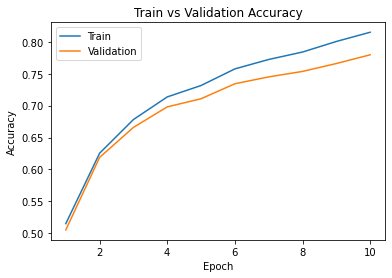

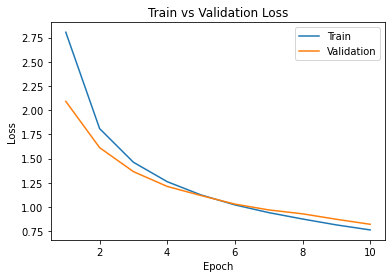

In [15]:
#Kooresh
kooresh_transfer2 = Transfer2()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer2.cuda()
    alexnet.cuda()
train(kooresh_transfer2, batch_size=256, num_epochs=10, learning_rate=1e-4, transfer=True)

In [ ]:
%%capture output
#Kooresh
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=256, num_epochs=10, learning_rate=1e-4, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.2163808345794678
20 elapsed time: 1.203584909439087
30 elapsed time: 1.2213740348815918
40 elapsed time: 1.2333037853240967
50 elapsed time: 1.2552859783172607
60 elapsed time: 1.2628884315490723
70 elapsed time: 1.2371273040771484
80 elapsed time: 1.279886245727539
90 elapsed time: 1.2296068668365479
100 elapsed time: 1.305211067199707
110 elapsed time: 1.1912403106689453
120 elapsed time: 1.262953758239746
130 elapsed time: 1.3113203048706055
140 elapsed time: 1.2326502799987793
150 elapsed time: 1.2853658199310303
160 elapsed time: 1.2229037284851074
170 elapsed time: 1.2212419509887695
epoch:  0
Elapsed time: 595.4244949817657
train acc: 0.4750573203036307 train loss: 2.925636974248019 val acc: 0.47328703085347934 val loss: 2.2065480038271112
60 elapsed time: 1.3156967163085938
70 elapsed time: 1.178

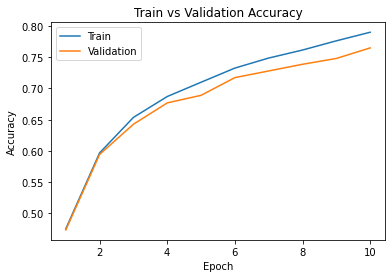

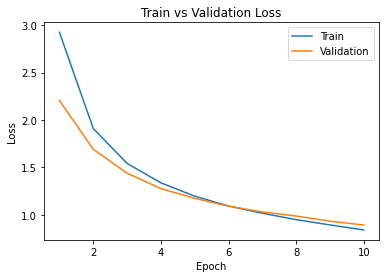

In [35]:
output.show()

In [ ]:
%%capture output2
#Kooresh
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=256, num_epochs=20, learning_rate=7e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.14735746383667
20 elapsed time: 1.182798147201538
30 elapsed time: 1.1766173839569092
40 elapsed time: 1.190058708190918
50 elapsed time: 1.23769211769104
60 elapsed time: 1.2323498725891113
70 elapsed time: 1.1929774284362793
80 elapsed time: 1.2469799518585205
90 elapsed time: 1.1799910068511963
100 elapsed time: 1.2695000171661377
110 elapsed time: 1.1265454292297363
120 elapsed time: 1.2275919914245605
130 elapsed time: 1.2831268310546875
140 elapsed time: 1.1924283504486084
150 elapsed time: 1.2206635475158691
160 elapsed time: 1.1813063621520996
170 elapsed time: 1.1876347064971924
epoch:  0
Elapsed time: 581.4642558097839
train acc: 0.4194065400796919 train loss: 3.1221735125238244 val acc: 0.41658875383998933 val loss: 2.4319207021745584
60 elapsed time: 1.3155131340026855
70 elapsed time: 1.1382

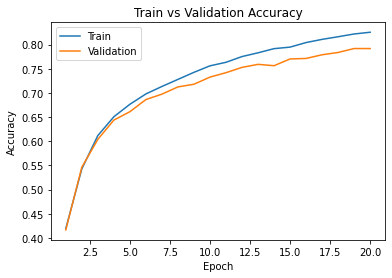

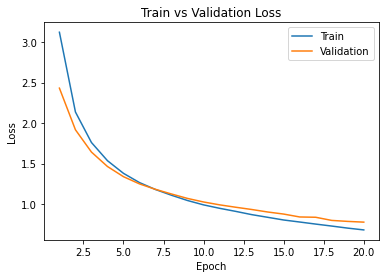

In [78]:
output2.show()

In [ ]:
%%capture output3
#Kooresh
kooresh_transfer4 = Transfer4()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer4.cuda()
    alexnet.cuda()
train(kooresh_transfer4, batch_size=256, num_epochs=10, learning_rate=1e-4, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.1987855434417725
20 elapsed time: 1.1909749507904053
30 elapsed time: 1.1964097023010254
40 elapsed time: 1.205704927444458
50 elapsed time: 1.2484467029571533
60 elapsed time: 1.2697746753692627
70 elapsed time: 1.2089824676513672
80 elapsed time: 1.2396092414855957
90 elapsed time: 1.2057907581329346
100 elapsed time: 1.2819674015045166
110 elapsed time: 1.1525044441223145
120 elapsed time: 1.2464282512664795
130 elapsed time: 1.2905514240264893
140 elapsed time: 1.2256600856781006
150 elapsed time: 1.2494583129882812
160 elapsed time: 1.1511447429656982
170 elapsed time: 1.1653635501861572
epoch:  0
Elapsed time: 588.7989122867584
train acc: 0.3762660552500946 train loss: 3.341761114922437 val acc: 0.3772539067717377 val loss: 2.782513214369952
60 elapsed time: 1.294499397277832
70 elapsed time: 1.134

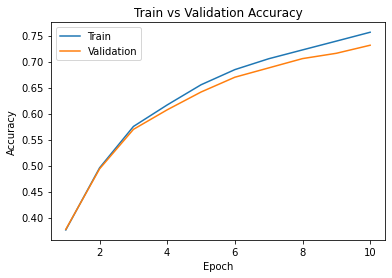

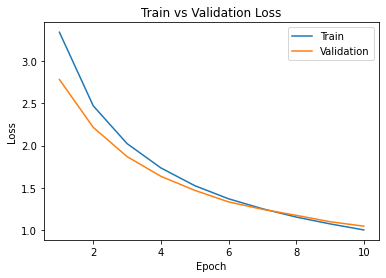

In [79]:
output3.show()

In [ ]:
%%capture output5
#Kooresh
kooresh_transfer4 = Transfer4()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer4.cuda()
    alexnet.cuda()
train(kooresh_transfer4, batch_size=256, num_epochs=20, learning_rate=7e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.1383588314056396
20 elapsed time: 1.1622474193572998
30 elapsed time: 1.1800172328948975
40 elapsed time: 1.1802613735198975
50 elapsed time: 1.2212648391723633
60 elapsed time: 1.222705602645874
70 elapsed time: 1.1760387420654297
80 elapsed time: 1.220088005065918
90 elapsed time: 1.1824159622192383
100 elapsed time: 1.2551991939544678
110 elapsed time: 1.1477835178375244
120 elapsed time: 1.2282378673553467
130 elapsed time: 1.2591161727905273
140 elapsed time: 1.1857109069824219
150 elapsed time: 1.2093939781188965
160 elapsed time: 1.1755144596099854
170 elapsed time: 1.1717288494110107
epoch:  0
Elapsed time: 581.4165160655975
train acc: 0.3243104868330254 train loss: 3.474601079117168 val acc: 0.3234272739414986 val loss: 2.9973036960019903
60 elapsed time: 1.3074219226837158
70 elapsed time: 1.13

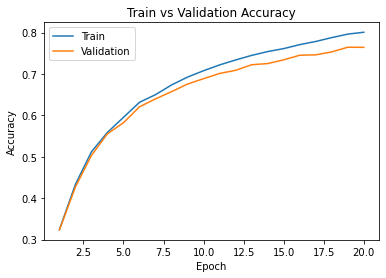

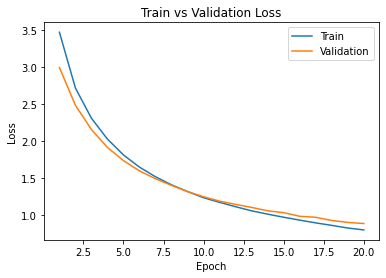

In [80]:
output5.show()

In [ ]:
%%capture output7
#Kooresh
kooresh_transfer4 = Transfer4()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer4.cuda()
    alexnet.cuda()
train(kooresh_transfer4, batch_size=256, num_epochs=10, learning_rate=1e-2, transfer=True)

In [ ]:
%%capture output9
#Kooresh  #BEST SO FAR
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=256, num_epochs=20, learning_rate=1e-4, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.1658494472503662
20 elapsed time: 1.2202770709991455
30 elapsed time: 1.210179090499878
40 elapsed time: 1.2348661422729492
50 elapsed time: 1.2508883476257324
60 elapsed time: 1.2574782371520996
70 elapsed time: 1.177678108215332
80 elapsed time: 1.240455150604248
90 elapsed time: 1.1988568305969238
100 elapsed time: 1.3116223812103271
110 elapsed time: 1.1540031433105469
120 elapsed time: 1.2468388080596924
130 elapsed time: 1.2811777591705322
140 elapsed time: 1.2061519622802734
150 elapsed time: 1.2490804195404053
160 elapsed time: 1.1942274570465088
170 elapsed time: 1.1718735694885254
epoch:  0
Elapsed time: 585.0333514213562
train acc: 0.48287068984707165 train loss: 2.8916948816993018 val acc: 0.47722719380259115 val loss: 2.17712157055483
60 elapsed time: 1.3089590072631836
70 elapsed time: 1.14

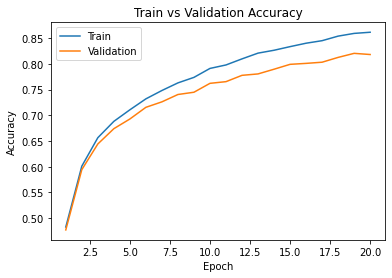

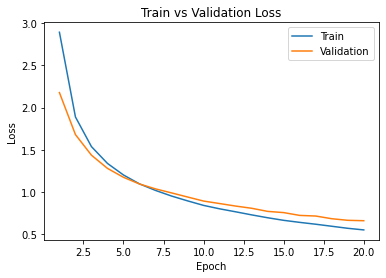

In [83]:
output9.show()

In [86]:
%%capture output10
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Transfer3_Kooresh-bs256-lr0.0001/model_Transfer3_Kooresh_bs256_lr0.0001_epoch19'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=10, learning_rate=1e-4, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.2578961849212646
20 elapsed time: 1.3017282485961914
30 elapsed time: 1.2538607120513916
40 elapsed time: 1.2603354454040527
50 elapsed time: 1.2918565273284912
60 elapsed time: 1.3339357376098633
70 elapsed time: 1.2355265617370605
80 elapsed time: 1.3164327144622803
90 elapsed time: 1.298097848892212
100 elapsed time: 1.3008649349212646
110 elapsed time: 1.1774976253509521
120 elapsed time: 1.2690963745117188
130 elapsed time: 1.3433880805969238
140 elapsed time: 1.2559950351715088
150 elapsed time: 1.252892255783081
160 elapsed time: 1.2004978656768799
170 elapsed time: 1.2048535346984863
epoch:  0
Elapsed time: 602.0380511283875
train acc: 0.8679963493088173 train loss: 0.5296439831568436 val acc: 0.8237611860558302 val loss: 0.6436127530316175
60 elapsed time: 1.3294031620025635
70 elapsed time: 1.1

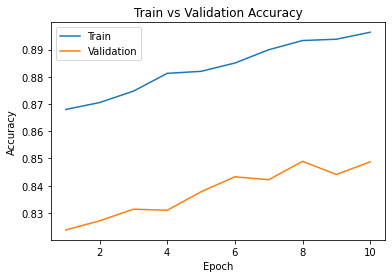

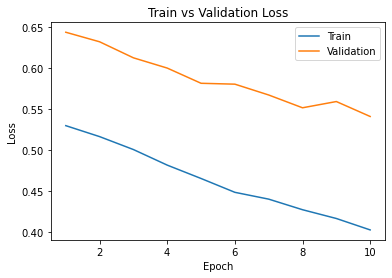

In [87]:
output10.show()

In [ ]:
%%capture output11
#Kooresh  #BEST SO FAR
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=256, num_epochs=30, learning_rate=8e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.2760398387908936
20 elapsed time: 1.1968634128570557
30 elapsed time: 1.2452752590179443
40 elapsed time: 1.2053649425506592
50 elapsed time: 1.2713088989257812
60 elapsed time: 1.373098611831665
70 elapsed time: 1.2026622295379639
80 elapsed time: 1.240952491760254
90 elapsed time: 1.2140722274780273
100 elapsed time: 1.2728073596954346
110 elapsed time: 1.2338156700134277
120 elapsed time: 1.2153267860412598
130 elapsed time: 1.299196720123291
140 elapsed time: 1.203425645828247
150 elapsed time: 1.2433035373687744
160 elapsed time: 1.2874836921691895
170 elapsed time: 1.1646144390106201
epoch:  0
Elapsed time: 594.4215395450592
train acc: 0.4377935578656813 train loss: 3.0440560349009256 val acc: 0.4251369039668759 val loss: 2.369474411010742
60 elapsed time: 1.3343796730041504
70 elapsed time: 1.1533

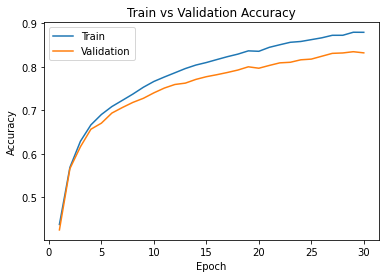

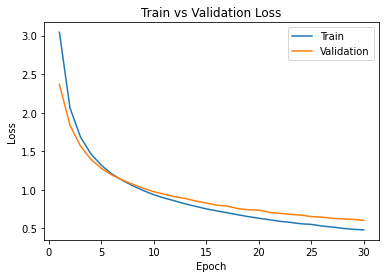

In [90]:
output11.show()

In [ ]:
%%capture output12
#Kooresh  #BEST SO FAR
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=225, num_epochs=40, learning_rate=4e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  200
Len val_loader:  67
Len test_loader:  67
All DataLoaders initialized for transfer model
10 elapsed time: 1.2794880867004395
20 elapsed time: 1.0575132369995117
30 elapsed time: 1.0963490009307861
40 elapsed time: 1.0201570987701416
50 elapsed time: 1.0769710540771484
60 elapsed time: 1.0483894348144531
70 elapsed time: 1.1159627437591553
80 elapsed time: 1.0511939525604248
90 elapsed time: 1.0235002040863037
100 elapsed time: 1.170405626296997
110 elapsed time: 1.066295862197876
120 elapsed time: 1.0661225318908691
130 elapsed time: 1.0621862411499023
140 elapsed time: 1.159440517425537
150 elapsed time: 1.1177597045898438
160 elapsed time: 1.0687637329101562
170 elapsed time: 1.076040506362915
180 elapsed time: 1.0693409442901611
190 elapsed time: 1.0036325454711914
200 elapsed time: 0.6906237602233887
epoch:  0
Elapsed time: 578.6889333724976
train acc: 0.3425862030585669 train loss: 3.4039315259456635 val 

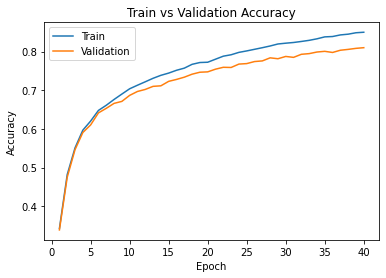

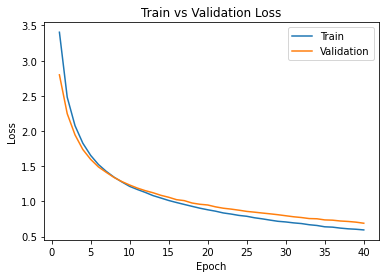

In [92]:
output12.show()

In [13]:
%%capture output15
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=512, num_epochs=10, learning_rate=8e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  88
Len val_loader:  30
Len test_loader:  30
All DataLoaders initialized for transfer model
10 elapsed time: 2.5800278186798096
20 elapsed time: 2.6664087772369385
30 elapsed time: 3.0031511783599854
40 elapsed time: 2.7082836627960205
50 elapsed time: 2.7199480533599854
60 elapsed time: 2.878499746322632
70 elapsed time: 2.8204073905944824
80 elapsed time: 2.5094964504241943
epoch:  0
Elapsed time: 629.3632090091705
train acc: 0.3425639427464773 train loss: 3.417619515549053 val acc: 0.34319487110992386 val loss: 2.7796280145645142
40 elapsed time: 2.80881667137146
50 elapsed time: 2.589759588241577
60 elapsed time: 2.8235087394714355
70 elapsed time: 2.5979230403900146
80 elapsed time: 2.4452133178710938
90 elapsed time: 2.8060789108276367
100 elapsed time: 2.443031072616577
110 elapsed time: 2.60099458694458
epoch:  1
Elapsed time: 623.7423741817474
train acc: 0.5004118157736571 train loss: 2.440799520774321 va

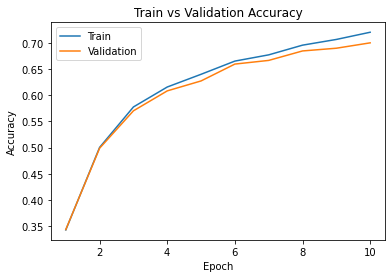

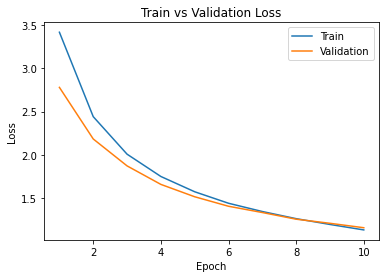

In [15]:
output15.show()

In [ ]:
%%capture output16
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=100, num_epochs=10, learning_rate=8e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  450
Len val_loader:  150
Len test_loader:  150
All DataLoaders initialized for transfer model
10 elapsed time: 0.48693346977233887
20 elapsed time: 0.533454179763794
30 elapsed time: 0.5368049144744873
40 elapsed time: 0.47896289825439453
50 elapsed time: 0.456373929977417
60 elapsed time: 0.5302934646606445
70 elapsed time: 0.5393650531768799
80 elapsed time: 0.5043787956237793
90 elapsed time: 0.4737277030944824
100 elapsed time: 0.5105218887329102
110 elapsed time: 0.5023491382598877
120 elapsed time: 0.5568161010742188
130 elapsed time: 0.5147414207458496
140 elapsed time: 0.4924318790435791
150 elapsed time: 0.4833667278289795
160 elapsed time: 0.4647049903869629
170 elapsed time: 0.49706244468688965
180 elapsed time: 0.5265636444091797
190 elapsed time: 0.4867899417877197
200 elapsed time: 0.46961045265197754
210 elapsed time: 0.5615651607513428
220 elapsed time: 0.4912261962890625
230 elapsed time: 0.48385

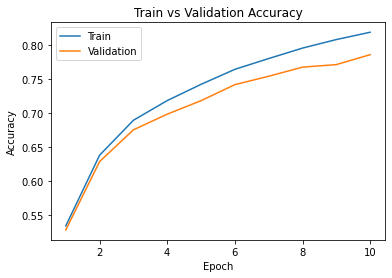

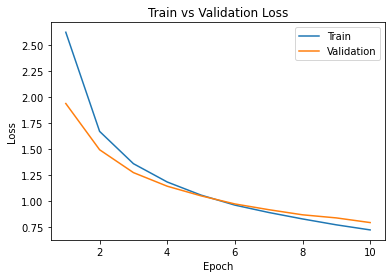

In [16]:
output16.show()